In [14]:
import sys

import spatialdata as sd

import troutpy 
import pandas as pd

from pathlib import Path

import pandas as pd
import scanpy as sc
import spatialdata as sd

# load and prepare data
import polars as pl
from sainsc import LazyKDE,GridCounts

from sainsc.io import read_Xenium
from sainsc.utils import celltype_signatures

# Customize function

# Read data and perform analysis

In [ ]:
import sys
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook
RESULTS_DIR='/media/sergio/Meninges/troutpy/xenium_msbrain'
compressed_transcript_csv = Path(RESULTS_DIR, 'sainsc', 'trans.csv.gz')

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

In [ ]:
# parameters
binsize_param=3
celltype_key='leiden'
background_filter=0.4

Dask DataFrame Structure:
                     x        y        z       feature_name cell_id nucleus_distance overlaps_nucleus fov_name is_gene       qv codeword_category codeword_index transcript_id segmentation_free_clusters bin_id overlaps_cell extracellular
npartitions=1                                                                                                                                                                                                                               
               float32  float32  float32  category[unknown]  string          float32            uint8   string    bool  float32            string          int32        uint64                      int64  int64         int64          bool
                   ...      ...      ...                ...     ...              ...              ...      ...     ...      ...               ...            ...           ...                        ...    ...           ...           ...
Dask Name: read-parquet, 1 graph layer

In [ ]:
transcripts_all = sdata.points["transcripts"][["feature_name", "x", "y", "codeword_category","overlaps_nucleus",'transcript_id','overlaps_cell']].compute()
transcripts_all = transcripts_all.reset_index(drop=True)
transcripts_all = transcripts_all.rename({"feature_name": "gene", "x": "x", "y": "y"})
transcripts_all = transcripts_all[transcripts_all["codeword_category"] == "predesigned_gene"]
transcripts_all= transcripts_all[transcripts_all['feature_name'].astype(str)!='nan']
transcripts=transcripts_all[["feature_name", "x", "y", "codeword_category"]]
transcripts.columns = ["gene", "x", "y", "codeword_category"]
transcripts.to_csv(compressed_transcript_csv, compression="gzip")

In [ ]:
n_threads = 16
# Read xenium file, rename columns and filter blanks/controls
transcripts = pl.read_csv(
    compressed_transcript_csv,
    columns=["gene", "x", "y"],
    schema_overrides={"gene": pl.Categorical},
    n_threads=n_threads,
)#.filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))

brain = LazyKDE.from_dataframe(transcripts, resolution=1000, binsize=binsize_param, n_threads=n_threads)

# Current status --reimplemented the rust function to compute dataframe from grid.
 The issue is that we need to see the most efficent way of retrieve counts while using Sainsc

In [ ]:
results, shape, transcript2bin_info=process_dataframe(transcripts, binsize=binsize_param, n_threads=n_threads)
# Assuming `transcript2bin_info` is a Polars DataFrame with 'bin_x' and 'bin_y' columns, we convert it to pandas df
transcript2bin_info=transcript2bin_info.to_pandas()
# This will create a new column `bin_x_y_id` as the concatenation of 'bin_x' and 'bin_y'
transcript2bin_info['bin_x_y_id']=transcript2bin_info['bin_x'].astype(str)+'_'+transcript2bin_info['bin_y'].astype(str)

# the following lines we do to make sure that xy match in both datasets
from tqdm import tqdm
xalls=[]
for f in tqdm(transcripts_all['x']):
    xalls.append(np.round(f,4))
yalls=[]
for f in tqdm(transcripts_all['y']):
    yalls.append(np.round(f,4))
###
transcripts_all['x']=xalls
transcripts_all['y']=yalls
transcripts_all['xy']=transcripts_all['x'].astype(str)+'_'+transcripts_all['y'].astype(str)
transcript2bin_info['xy']=transcript2bin_info['x'].astype(str)+'_'+transcript2bin_info['y'].astype(str)
id2overlap=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_nucleus']))
id2overlap_cell=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_cell']))
transcript2bin_info['overlaps_nucleus']=transcript2bin_info['xy'].map(id2overlap)
transcript2bin_info['overlaps_cell']=transcript2bin_info['xy'].map(id2overlap_cell)

from tqdm import tqdm
xalls=[]
for f in tqdm(transcripts_all['x']):
    xalls.append(np.round(f,4))
yalls=[]
for f in tqdm(transcripts_all['y']):
    yalls.append(np.round(f,4))
###
transcripts_all['x']=xalls
transcripts_all['y']=yalls
transcripts_all['xy']=transcripts_all['x'].astype(str)+'_'+transcripts_all['y'].astype(str)
transcript2bin_info['xy']=transcript2bin_info['x'].astype(str)+'_'+transcript2bin_info['y'].astype(str)
id2overlap=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_nucleus']))
id2overlap_cell=dict(zip(transcripts_all['xy'],transcripts_all['overlaps_cell']))
transcript2bin_info['overlaps_nucleus']=transcript2bin_info['xy'].map(id2overlap)
transcript2bin_info['overlaps_cell']=transcript2bin_info['xy'].map(id2overlap_cell)

Before we start it is good to get a brief overview of the two main Classes in sainsc.

- GridCounts: This class holds the data as a dictionary of sparse matrices of the same shape. You rarely will need to interact with it directly unless you want to, filter the genes or crop/mask the sample. It mostly behaves like a Python dictionary but is implemented in Rust. Therefore, iterating over the count matrices of each gene might be slow as the data needs to be transformed every time.
- LazyKDE: This is the class that you mostly will interact with. It contains a GridCounts instance in its counts attribute and otherwise exposes almost all methods necessary to perform the analysis.
We will use the transcripts.csv.gz (or transcripts.parquet) to load the locations of all identified transcripts. The control probes from the Xenium study will be automatically filtered out.

We can furthermore specify the size of the bins we will asign the transcripts into (by default this is set to 0.5 um) and the number of threads we want to use to process the data.

There are options to directly load data from common file formats/technologies such as Stereo-seq, Xenium, and Vizgen. If none of the options fit for your use case you can have a look at LazyKDE.from_dataframe or GridCounts.from_dataframe methods.

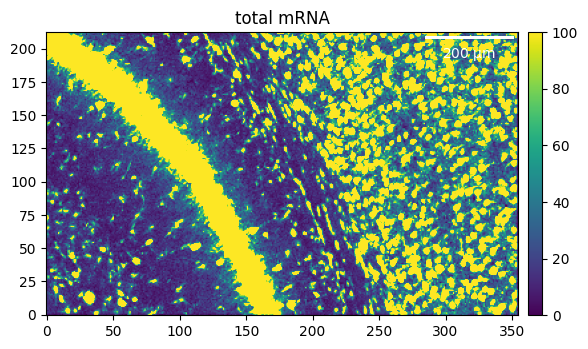

In [ ]:
brain.calculate_total_mRNA()
_ = brain.plot_genecount(im_kwargs={"vmax": 100})
_ = brain.plot_genecount_histogram()

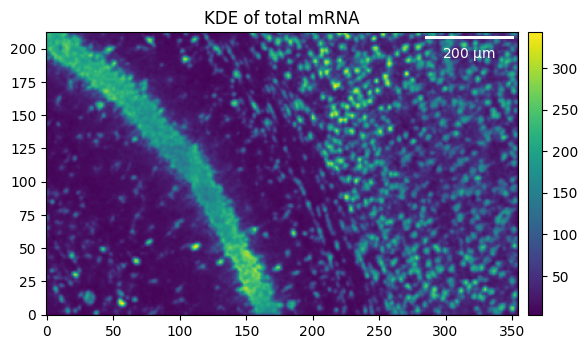

In [ ]:
brain.gaussian_kernel(2.5, unit="um")
brain.calculate_total_mRNA_KDE()
_ = brain.plot_KDE()

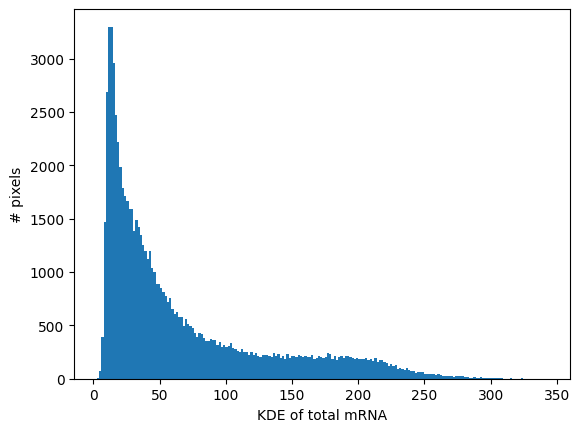

In [349]:
_ = brain.plot_KDE_histogram(bins=200)

In [ ]:
brain.filter_background(background_filter)

In [ ]:
adata = sdata["table"]
expr = adata.to_df()
expr["cell type"] = adata.obs[celltype_key]
signatures = expr.groupby("cell type").mean().transpose()

In [353]:
brain.assign_celltype(signatures, log=True)

In [354]:
import colorcet as cc
import seaborn as sns

cmap = dict(zip(brain.celltypes, sns.color_palette(cc.glasbey, n_colors=len(brain.celltypes)), strict=False))

_ = brain.plot_celltype_map(cmap=cmap)

In [355]:
_ = brain.plot_assignment_score(remove_background=True)
_ = brain.plot_cosine_similarity()

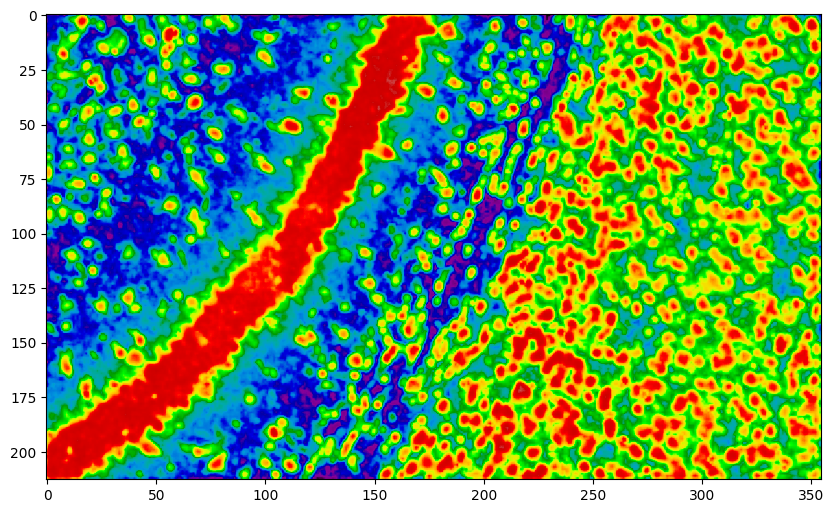

In [356]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(brain.cosine_similarity.transpose(), cmap="nipy_spectral", vmax=0.9)

In [ ]:
import numpy as np
import pandas as pd

# Flattened features
celltype = brain.celltype_map.flatten()
assignment_score = brain.assignment_score.flatten()
cosine_similarity = brain.cosine_similarity.flatten()

# Calculate x, y coordinates based on the matrix shape
n_rows, n_cols = brain.celltype_map.shape  # Assuming brain.shape gives the shape of the matrix
x_coordinates, y_coordinates = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

# Flatten the x and y coordinates to match the flattened data
x_coordinates = x_coordinates.flatten()
y_coordinates = y_coordinates.flatten()

# Create the DataFrame with the extracted features and coordinates
output_df = pd.DataFrame({"bin_x": x_coordinates, "bin_y": y_coordinates,
    "cell type": celltype, "assignment_score": assignment_score, "cosine_similarity": cosine_similarity})

# Map the cell type numbers to their actual names
num2ct = dict(zip(range(0, len(brain.celltypes)), brain.celltypes, strict=False))
output_df["cell type"] = output_df["cell type"].map(num2ct)

output_df['bin_x_y_id']=output_df['bin_y'].astype(str)+'_'+output_df['bin_x'].astype(str)

# View the final DataFrame
output_df.head()


bin_x  bin_y cell type  assignment_score  cosine_similarity bin_x_y_id
0      0      0         1          0.112851           0.245814        0_0
1      1      0         1          0.083987           0.249253        0_1
2      2      0         1          0.031190           0.233372        0_2
3      3      0         1          0.054114           0.234161        0_3
4      4      0         1          0.074469           0.256074        0_4

In [ ]:
bin2celltype=dict(zip(output_df['bin_x_y_id'],output_df['cell type']))
bin2cosine_similarity=dict(zip(output_df['bin_x_y_id'],output_df['cosine_similarity']))
bin2assignment_score=dict(zip(output_df['bin_x_y_id'],output_df['assignment_score']))
transcript2bin_info['closest_cell_type']=transcript2bin_info['bin_x_y_id'].map(bin2celltype)
transcript2bin_info['cosine_similarity']=transcript2bin_info['bin_x_y_id'].map(bin2cosine_similarity)

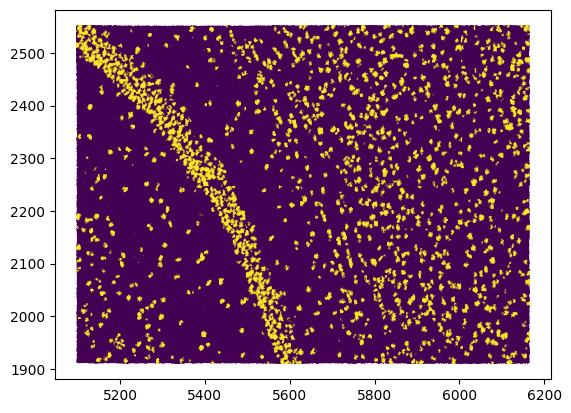

In [ ]:
plt.scatter(transcript2bin_info['x'],transcript2bin_info['y'],c=transcript2bin_info['overlaps_nucleus'],s=0.1)
plt.figure()
plt.scatter(transcript2bin_info['x'],transcript2bin_info['y'],c=transcript2bin_info['cosine_similarity'],s=0.1)

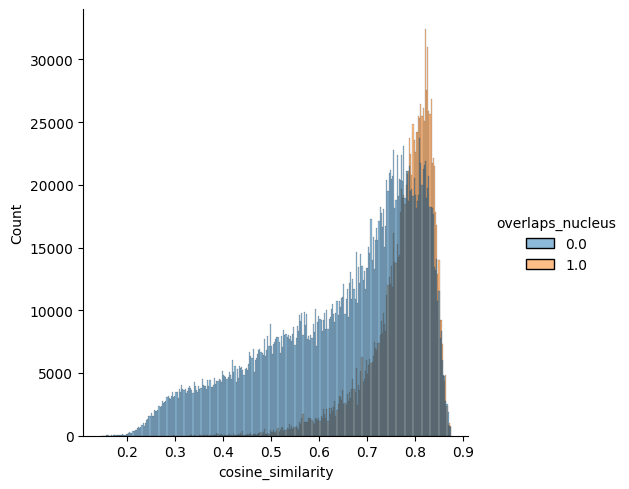

In [336]:
sns.displot(transcript2bin_info,x='cosine_similarity',hue='overlaps_nucleus')

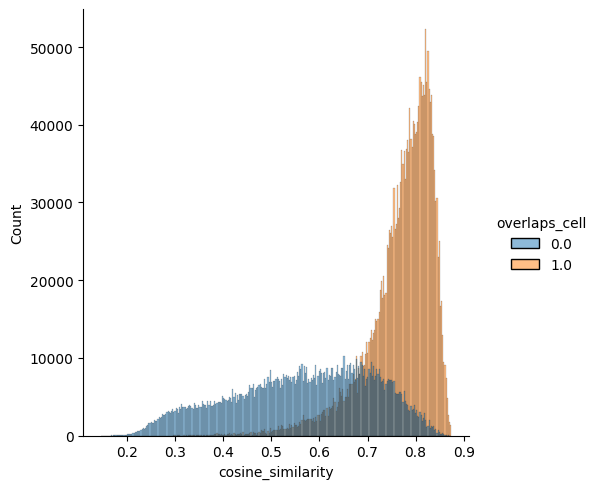

In [362]:
sns.displot(transcript2bin_info,x='cosine_similarity',hue='overlaps_cell')

In [389]:
# we should make the overlaps_cell column flexible, depending on the key specified. We also should make the percentile dependent on the given input
threshold=np.percentile(transcript2bin_info.loc[transcript2bin_info['overlaps_cell']==1,'cosine_similarity'],10)
transcript2bin_info['match_cell_signature']=transcript2bin_info['cosine_similarity']>threshold
print(threshold)

0.6785410046577454


In [ ]:
xy2cosine_similarity=dict(zip(transcript2bin_info['xy'],transcript2bin_info['cosine_similarity']))
xy2closest_cell_type=dict(zip(transcript2bin_info['xy'],transcript2bin_info['closest_cell_type']))
transcripts_all['cosine_similarity']=transcripts_all['xy'].map(xy2cosine_similarity)
transcripts_all['closest_cell_type']=transcripts_all['xy'].map(xy2closest_cell_type)
id2cosine=dict(zip(transcripts_all.index,transcripts_all['cosine_similarity']))
id2ct=dict(zip(transcripts_all.index,transcripts_all['closest_cell_type']))
transi=sdata.points["transcripts"].compute()
transi['cosine_similarity']=transi.index.map(id2cosine)
transi['closest_cell_type']=transi.index.map(id2ct)
transi['match_cell_signature']=transi['cosine_similarity']>threshold

# now we reformat transcripts as points.

### plot cosine similarity by cell type

In [ ]:
for g,i in transcript2bin_info.groupby('closest_cell_type'):
    sns.displot(i,x='cosine_similarity',hue='overlaps_cell')
    plt.title(g)
    plt.show()

# Function implementation [TO BE ADDED TO PACKAGE]

In [ ]:
import polars as pl
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from multiprocessing import Pool
from functools import partial

def process_dataframe(df: pl.DataFrame, binsize: float = None, n_threads: int = 4):
    """
    Process a Polars DataFrame by binning spatial coordinates, converting genes to categorical,
    and constructing sparse matrices for each gene.
    
    Args:
        df (pl.DataFrame): Input data containing "x", "y", "gene", "count".
        binsize (float, optional): Binning size for spatial coordinates.
        n_threads (int): Number of threads for parallel processing.
    
    Returns:
        dict: Dictionary of sparse matrices for each gene.
        tuple: Shape of the spatial grid.
        pl.DataFrame: DataFrame with bin assignments.
    """
    
    # Apply binning if provided
    if binsize:
        df = df.with_columns(
            (df["x"] / binsize).floor().alias("bin_x"),
            (df["y"] / binsize).floor().alias("bin_y")
        )
    else:
        df = df.with_columns(
            df["x"].alias("bin_x"),
            df["y"].alias("bin_y")
        )
    
    # Convert to integer type and shift coordinates to start at 0
    df = df.with_columns(
        (df["bin_x"] - df["bin_x"].min()).cast(pl.Int32).alias("bin_x"),
        (df["bin_y"] - df["bin_y"].min()).cast(pl.Int32).alias("bin_y")
    )
    
    # Ensure "count" column exists, otherwise fill with ones
    if "count" not in df.columns:
        df = df.with_columns(pl.lit(1, dtype=pl.UInt32).alias("count"))
    else:
        df = df.with_columns(df["count"].cast(pl.UInt32))
    
    # Ensure "gene" is categorical
    df = df.with_columns(df["gene"].cast(pl.Categorical))

    # Compute the shape of the spatial grid
    shape = (df["bin_x"].max() + 1, df["bin_y"].max() + 1)

    # Partition DataFrame by gene for parallel processing
    gene_groups = df.partition_by("gene", maintain_order=False)

    # Use partial to pass the shape argument
    process_gene_partial = partial(process_gene, shape=shape)

    with Pool(n_threads) as pool:
        results = dict(pool.map(process_gene_partial, gene_groups))

    return results, shape, df

def process_gene(group, shape):
    """Convert a gene DataFrame into a sparse matrix."""
    gene_name = group["gene"][0]
    x = group["bin_x"].to_numpy()
    y = group["bin_y"].to_numpy()
    counts = group["count"].to_numpy()
        
    # Convert to CSR sparse matrix
    sparse_matrix = coo_matrix((counts, (x, y)), shape=shape).tocsr()
        
    return gene_name, sparse_matrix

def integrated_sainsc_processing(
    sdata,
    binsize=3,
    celltype_key='leiden',
    background_filter=0.4,
    gaussian_kernel_key=2.5,
    n_threads=16,
    return_sainsc=False,
    copy=False,
    compressed_transcript_csv_path="compressed_transcript.csv.gz"
):
    """
    Process an sdata object by running an integrated sainsc analysis pipeline.
    
    This function extracts transcript information from sdata, prepares the data,
    bins it using sainsc tools (including a KDE and cell type assignment), and then
    maps cosine similarity and cell type assignment results back to the original sdata.
    
    Parameters
    ----------
    sdata : spatialdata object
        An object containing spatial points (with a key "transcripts") and a table
        of expression data. The object is expected to have attributes such as `points`
        and support a ["table"] lookup.
    binsize : int, optional (default=3)
        Bin size parameter to be used in the sainsc processing.
    celltype_key : str, optional (default='leiden')
        Key in sdata table metadata to use for grouping cell types.
    background_filter : float, optional (default=0.4)
        Threshold used for background filtering in the KDE calculation.
    gaussian_kernel_key : float, optional (default=2.5)
        Parameter controlling the gaussian kernel smoothing (unit: µm).
    n_threads : int, optional (default=16)
        Number of threads to use for processing.
    return_sainsc : bool, optional (default=False)
        If True, the function returns a tuple of (sdata, sainsc_output) where
        sainsc_output is a dictionary containing intermediate outputs.
    copy : bool, optional (default=True)
        If True, the function works on a copy of sdata and returns it.
        Otherwise, sdata is modified in place and None is returned (aside from sainsc_output).
    compressed_transcript_csv_path : str, optional (default="compressed_transcript.csv.gz")
        File path to store the temporary CSV of transcript data (gzip compressed).
    
    Returns
    -------
    sdata or (sdata, sainsc_output) : spatialdata object or tuple
        The modified sdata object (with updated transcript points) is returned.
        If return_sainsc is True, a tuple (modified sdata, sainsc_output) is returned,
        where sainsc_output is a dict containing:
            - "brain": the LazyKDE object with KDE and cell type assignment results,
            - "transcript2bin_info": a pandas DataFrame with binned transcript information,
            - "output_df": a DataFrame summarizing binned cell type and cosine similarity,
            - "threshold": the cosine similarity threshold computed from the data.
    """
    import numpy as np
    import pandas as pd
    import polars as pl
    from tqdm import tqdm
    import spatialdata as sd
    from sainsc import LazyKDE, GridCounts # , process_dataframe  # process_dataframe is assumed to be available


    # -------------------------------------------------------------------------
    # 1. Load and prepare transcript data from sdata.points
    # -------------------------------------------------------------------------
    # Extract relevant columns and compute the Dask/polars DataFrame
    transcripts_all = (
        sdata.points["transcripts"]
        [["feature_name", "x", "y", "codeword_category", "overlaps_nucleus", "transcript_id", "overlaps_cell"]]
        .compute()
        .reset_index(drop=True)
    )
    # Rename for clarity and filter by desired gene type
    transcripts_all = transcripts_all.rename(columns={"feature_name": "gene"})
    transcripts_all = transcripts_all[transcripts_all["codeword_category"] == "predesigned_gene"]
    # Remove rows where the gene is not valid (e.g. string "nan")
    transcripts_all = transcripts_all[transcripts_all["gene"].astype(str) != "nan"]
    
    # Create a smaller DataFrame for CSV export
    transcripts = transcripts_all[["gene", "x", "y", "codeword_category"]].copy()
    transcripts.columns = ["gene", "x", "y", "codeword_category"]
    
    # Save to a compressed CSV file (temporary file)
    transcripts.to_csv(compressed_transcript_csv_path, compression="gzip", index=False)
    
    # Read the CSV using Polars for fast processing
    transcripts = pl.read_csv(
        compressed_transcript_csv_path,
        columns=["gene", "x", "y"],
        schema_overrides={"gene": pl.Categorical},
        n_threads=n_threads,
    )
    
    # -------------------------------------------------------------------------
    # 2. Create a brain object using LazyKDE and process transcript data
    # -------------------------------------------------------------------------
    brain = LazyKDE.from_dataframe(transcripts, resolution=1000, binsize=binsize, n_threads=n_threads)
    
    # Process the transcripts into binned data
    results, shape, transcript2bin_info = process_dataframe(transcripts, binsize=binsize, n_threads=n_threads)
    transcript2bin_info = transcript2bin_info.to_pandas()  # Convert to pandas for easier manipulation
    transcript2bin_info["bin_x_y_id"] = transcript2bin_info["bin_x"].astype(str) + "_" + transcript2bin_info["bin_y"].astype(str)
    
    # -------------------------------------------------------------------------
    # 3. Align coordinates and map overlap information
    # -------------------------------------------------------------------------
    # Round x and y coordinates to 4 decimal places for consistency
    transcripts_all["x"] = transcripts_all["x"].round(4)
    transcripts_all["y"] = transcripts_all["y"].round(4)
    transcripts_all["xy"] = transcripts_all["x"].astype(str) + "_" + transcripts_all["y"].astype(str)
    
    transcript2bin_info["xy"] = transcript2bin_info["x"].astype(str) + "_" + transcript2bin_info["y"].astype(str)
    
    # Map overlap information (from nucleus and cell) from transcripts_all to transcript2bin_info
    id2overlap = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_nucleus"]))
    id2overlap_cell = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_cell"]))
    transcript2bin_info["overlaps_nucleus"] = transcript2bin_info["xy"].map(id2overlap)
    transcript2bin_info["overlaps_cell"] = transcript2bin_info["xy"].map(id2overlap_cell)
    
    # -------------------------------------------------------------------------
    # 4. Run KDE, background filtering and cell type assignment
    # -------------------------------------------------------------------------
    brain.calculate_total_mRNA()
    brain.gaussian_kernel(gaussian_kernel_key, unit="um")
    brain.calculate_total_mRNA_KDE()
    brain.filter_background(background_filter)
    
    # Retrieve expression data from sdata table and compute cell type signatures
    adata = sdata["table"]
    expr = adata.to_df()
    expr["cell type"] = adata.obs[celltype_key]
    signatures = expr.groupby("cell type").mean().transpose()
    
    # Assign cell types to the brain (KDE) object
    brain.assign_celltype(signatures, log=True)
    
    # -------------------------------------------------------------------------
    # 5. Map binned features (cell type, assignment score, cosine similarity)
    # -------------------------------------------------------------------------
    # Flatten the binned cell type map, assignment scores, and cosine similarity matrix
    celltype_flat = brain.celltype_map.flatten()
    assignment_score_flat = brain.assignment_score.flatten()
    cosine_similarity_flat = brain.cosine_similarity.flatten()
    
    # Get the bin grid coordinates based on the shape of the cell type map
    n_rows, n_cols = brain.celltype_map.shape
    x_coordinates, y_coordinates = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    
    # Create a DataFrame summarizing the binned data
    output_df = pd.DataFrame({
        "bin_x": x_coordinates,
        "bin_y": y_coordinates,
        "cell type": celltype_flat,
        "assignment_score": assignment_score_flat,
        "cosine_similarity": cosine_similarity_flat
    })
    # Map cell type indices to actual names using the brain's celltypes list
    num2ct = dict(zip(range(len(brain.celltypes)), brain.celltypes))
    output_df["cell type"] = output_df["cell type"].map(num2ct)
    output_df["bin_x_y_id"] = output_df["bin_y"].astype(str) + "_" + output_df["bin_x"].astype(str)
    
    # Build mapping dictionaries from binned information
    bin2celltype = dict(zip(output_df["bin_x_y_id"], output_df["cell type"]))
    bin2cosine_similarity = dict(zip(output_df["bin_x_y_id"], output_df["cosine_similarity"]))
    
    # Map the bin-level assignments to the transcript-level information
    transcript2bin_info["closest_cell_type"] = transcript2bin_info["bin_x_y_id"].map(bin2celltype)
    transcript2bin_info["cosine_similarity"] = transcript2bin_info["bin_x_y_id"].map(bin2cosine_similarity)
    
    # Compute a threshold based on the 10th percentile of cosine similarity for transcripts overlapping cells
    threshold = np.percentile(transcript2bin_info.loc[transcript2bin_info["overlaps_cell"] == 1, "cosine_similarity"], 10)
    transcript2bin_info["match_cell_signature"] = transcript2bin_info["cosine_similarity"] > threshold
    
    # -------------------------------------------------------------------------
    # 6. Map back the cosine similarity and cell type to the original transcripts
    # -------------------------------------------------------------------------
    xy2cosine_similarity = dict(zip(transcript2bin_info["xy"], transcript2bin_info["cosine_similarity"]))
    xy2closest_cell_type = dict(zip(transcript2bin_info["xy"], transcript2bin_info["closest_cell_type"]))
    
    transcripts_all["cosine_similarity"] = transcripts_all["xy"].map(xy2cosine_similarity)
    transcripts_all["closest_cell_type"] = transcripts_all["xy"].map(xy2closest_cell_type)
    
    # Build dictionaries to map by original transcript index
    id2cosine = dict(zip(transcripts_all.index, transcripts_all["cosine_similarity"]))
    id2ct = dict(zip(transcripts_all.index, transcripts_all["closest_cell_type"]))
    
    # Retrieve the original transcripts data from sdata and update with new features
    transi = sdata.points["transcripts"].compute()
    transi["cosine_similarity"] = transi.index.map(id2cosine)
    transi["closest_cell_type"] = transi.index.map(id2ct)
    transi["match_cell_signature"] = transi["cosine_similarity"] > threshold
    
    # Reformat the updated transcripts DataFrame into a spatialdata Points model
    sdata.points["transcripts"] = sd.models.PointsModel.parse(transi)
    
    # Prepare optional sainsc output for further inspection
    sainsc_output = {
        "brain": brain,
        "transcript2bin_info": transcript2bin_info,
        "output_df": output_df,
        "threshold": threshold
    }
    
    if return_sainsc:
        return sdata, sainsc_output
    else:
        return sdata


In [425]:
sdata=integrated_sainsc_processing(
    sdata,binsize=3,
    celltype_key='leiden',background_filter=0.4,
    gaussian_kernel_key=2.5,n_threads=16,
    return_sainsc=False,copy=True,
    compressed_transcript_csv_path="compressed_transcript.csv.gz")

In [ ]:
sdata.obs['']

SpatialData object, with associated Zarr store: /media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 5000), (5, 1500, 2500), (5, 750, 1250), (5, 375, 625), (5, 188, 312)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
│     └── 'nucleus_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 20) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1762, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (1722, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (1750, 1) (2D shapes)
└── Tables
      ├── 'segmentation_free_table': AnnData (2114819, 13035)
      ├── 'source_score': AnnData (834299, 10)
      ├── 'table': AnnData (1703, 4226)
      ├── 'target_score': AnnData (834299, 

In [224]:
filt = list((output_df["cell type"] == "Astro") & (output_df["cosine_similarity"] > 0.5))

In [225]:
import numpy as np
from tqdm import tqdm

allres = np.zeros([np.sum(filt), len(embryo.counts.genes())])
n = 0
for g in tqdm(embryo.counts.genes()):
    allres[:, n] = embryo.counts.get(g).todense().flatten()[filt]
    n = n + 1

100%|██████████| 5006/5006 [00:19<00:00, 262.47it/s]


In [226]:
import scanpy as sc

adata = sc.AnnData(allres)
adata.var.index = embryo.counts.genes()

In [227]:
x_coords, y_coords = np.meshgrid(np.arange(embryo.celltype_map.shape[1]), np.arange(embryo.celltype_map.shape[0]))

In [228]:
adata.obs["x"] = x_coords.flatten()[filt]
adata.obs["y"] = y_coords.flatten()[filt]

In [229]:
adata.obs["cosine_similarity"] = output_df["cosine_similarity"][filt]

In [230]:
adata.obsm["spatial"] = np.array(adata.obs.loc[:, ["y", "x"]])

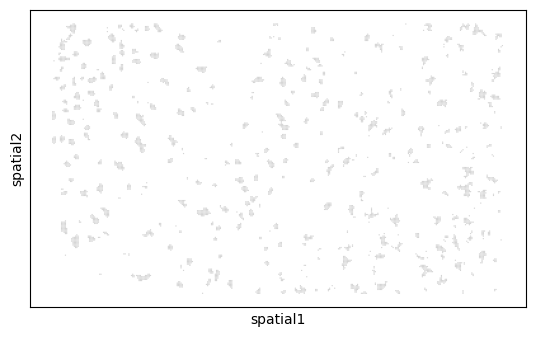

In [233]:
sc.pl.spatial(adata, spot_size=1)

In [234]:
adata

AnnData object with n_obs × n_vars = 4411 × 5006
    obs: 'x', 'y', 'cosine_similarity'
    obsm: 'spatial'

In [235]:
adata.obs["total_counts"] = np.sum(adata.X, axis=1)

In [236]:
sc.pp.filter_cells(adata, min_counts=5)

In [237]:
sc.pp.filter_cells(adata, min_genes=3)

In [238]:
adata

AnnData object with n_obs × n_vars = 4408 × 5006
    obs: 'x', 'y', 'cosine_similarity', 'total_counts', 'n_counts', 'n_genes'
    obsm: 'spatial'

(array([248., 715., 938., 759., 461., 353., 227., 180., 160.,  81.,  85.,
         75.,  41.,  33.,  23.,  11.,  11.,   4.,   2.,   1.]),
 array([  5.  ,  20.85,  36.7 ,  52.55,  68.4 ,  84.25, 100.1 , 115.95,
        131.8 , 147.65, 163.5 , 179.35, 195.2 , 211.05, 226.9 , 242.75,
        258.6 , 274.45, 290.3 , 306.15, 322.  ]),
 <BarContainer object of 20 artists>)

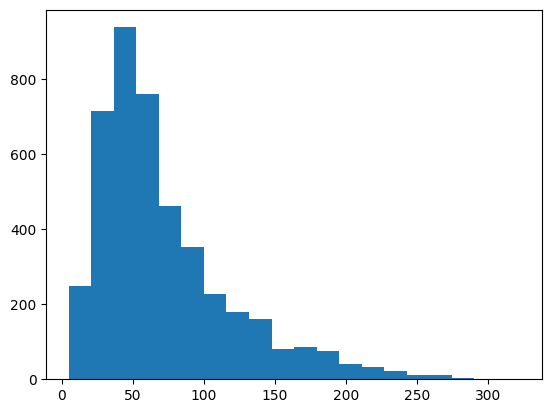

In [239]:
plt.hist(adata.obs["n_counts"], bins=20)

In [240]:
adata.layers["raw"] = adata.X

In [241]:
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)

In [257]:
adata

AnnData object with n_obs × n_vars = 4408 × 5006
    obs: 'x', 'y', 'cosine_similarity', 'total_counts', 'n_counts', 'n_genes', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

In [255]:
seed = 42
sc.pp.pca(adata)

In [258]:
sc.pp.neighbors(adata, random_state=seed, n_pcs=0, n_neighbors=10)

In [264]:
sc.tl.umap(adata, min_dist=0.03, random_state=seed)

In [266]:
sc.tl.leiden(adata, resolution=0.7, random_state=seed)

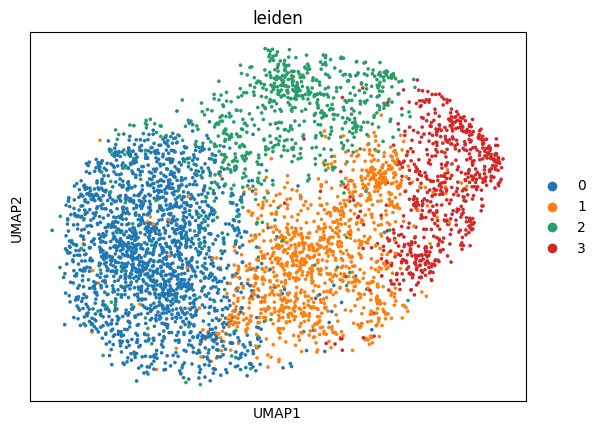

In [267]:
sc.pl.umap(adata, color="leiden")

In [273]:
adata.obs.to_csv("/media/sergio/Discovair_final/leiden_clust.csv")

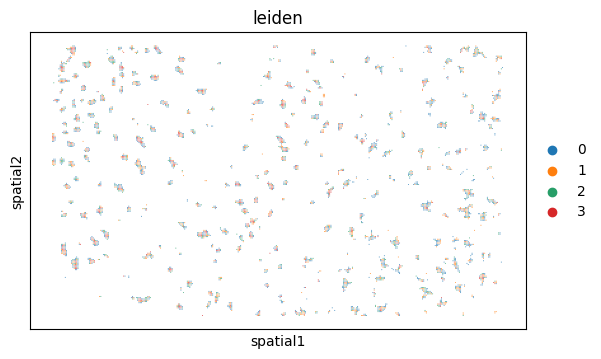

In [272]:
sc.pl.spatial(adata, spot_size=0.7, color="leiden")

In [ ]:
# Plot per cell type

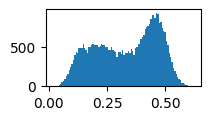

10


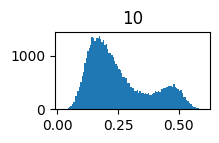

11


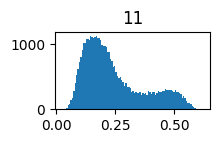

12


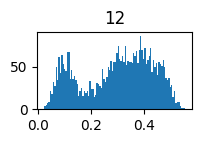

3


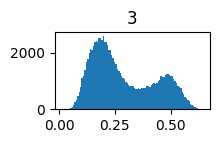

4


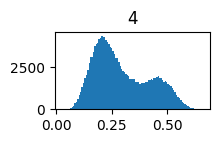

5


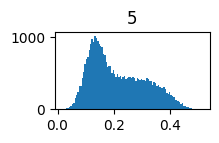

7


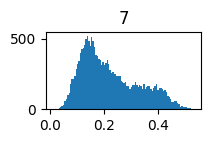

9


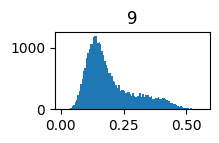

Astro


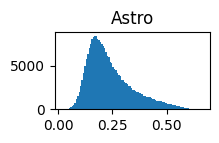

CA


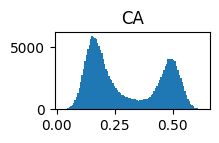

INH


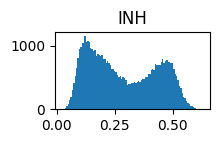

Oligo


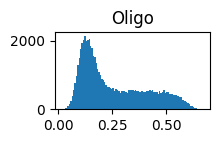

In [48]:
import matplotlib.pyplot as plt

for n, g in output_df.groupby("cell type"):
    print(n)
    plt.figure(figsize=(2, 1))
    ss = plt.hist(g["cosine_similarity"], bins=100)
    plt.title(n)
    plt.show()

In [103]:
# de novo signature identification

In [105]:
embryo.find_local_maxima(4, min_area=60)
print(embryo)

cellproxy_adata = embryo.load_local_maxima(embryo.genes)
print(cellproxy_adata)

LazyKDE (16 threads)
    genes: 5006
    shape: (1329, 798)
    resolution: 800.0 nm / px
    kernel: (11, 11)
    background: set
    local maxima: 2708
    celltypes: 13
AnnData object with n_obs × n_vars = 2708 × 5006
    obs: 'total_mRNA_KDE', 'cosine_similarity', 'assignment_score', 'celltype'
    obsm: 'spatial'


/home/sergio/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [106]:
import scanpy as sc

# remove potential genes w/o counts
cellproxy_adata = cellproxy_adata[:, cellproxy_adata.X.sum(axis=0).A1 > 0].copy()

# "normalize" data
sc.pp.normalize_total(cellproxy_adata)
sc.pp.log1p(cellproxy_adata)

/home/sergio/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/sergio/.local/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 5003 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1052381/1407398117.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(cellproxy_adata, resolution=1.5, random_state=seed)


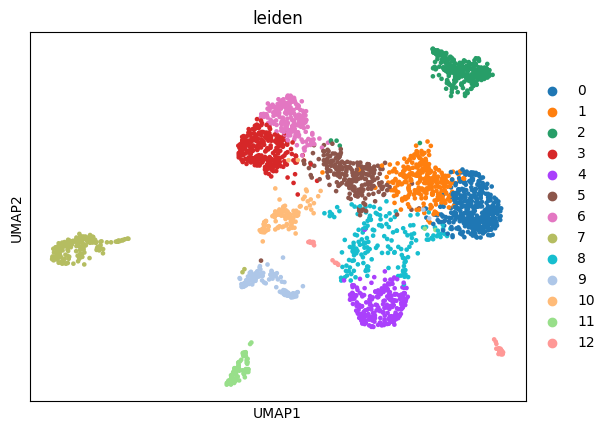

In [ ]:
seed = 42
sc.pp.neighbors(cellproxy_adata, random_state=seed)
sc.tl.umap(cellproxy_adata, min_dist=0.1, random_state=seed)
sc.tl.leiden(cellproxy_adata, resolution=1.5, random_state=seed)
sc.pl.umap(cellproxy_adata, color="leiden")

In [113]:
from sainsc.utils import celltype_signatures

signatures_denovo = celltype_signatures(cellproxy_adata, celltype_col="leiden")
embryo.assign_celltype(signatures_denovo, log=True)

: 

In [ ]:
cmap_denovo = dict(
    zip(
        cellproxy_adata.obs["leiden"].cat.categories,
        cellproxy_adata.uns["leiden_colors"],
        strict=False,
    )
)

_ = embryo.plot_celltype_map(cmap=cmap_denovo)

In [4]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr). Please see the
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from /media/sergio/Discovair_final/mousebrain_prime_crop.zarr the 
         new file path: /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr                    


/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing th

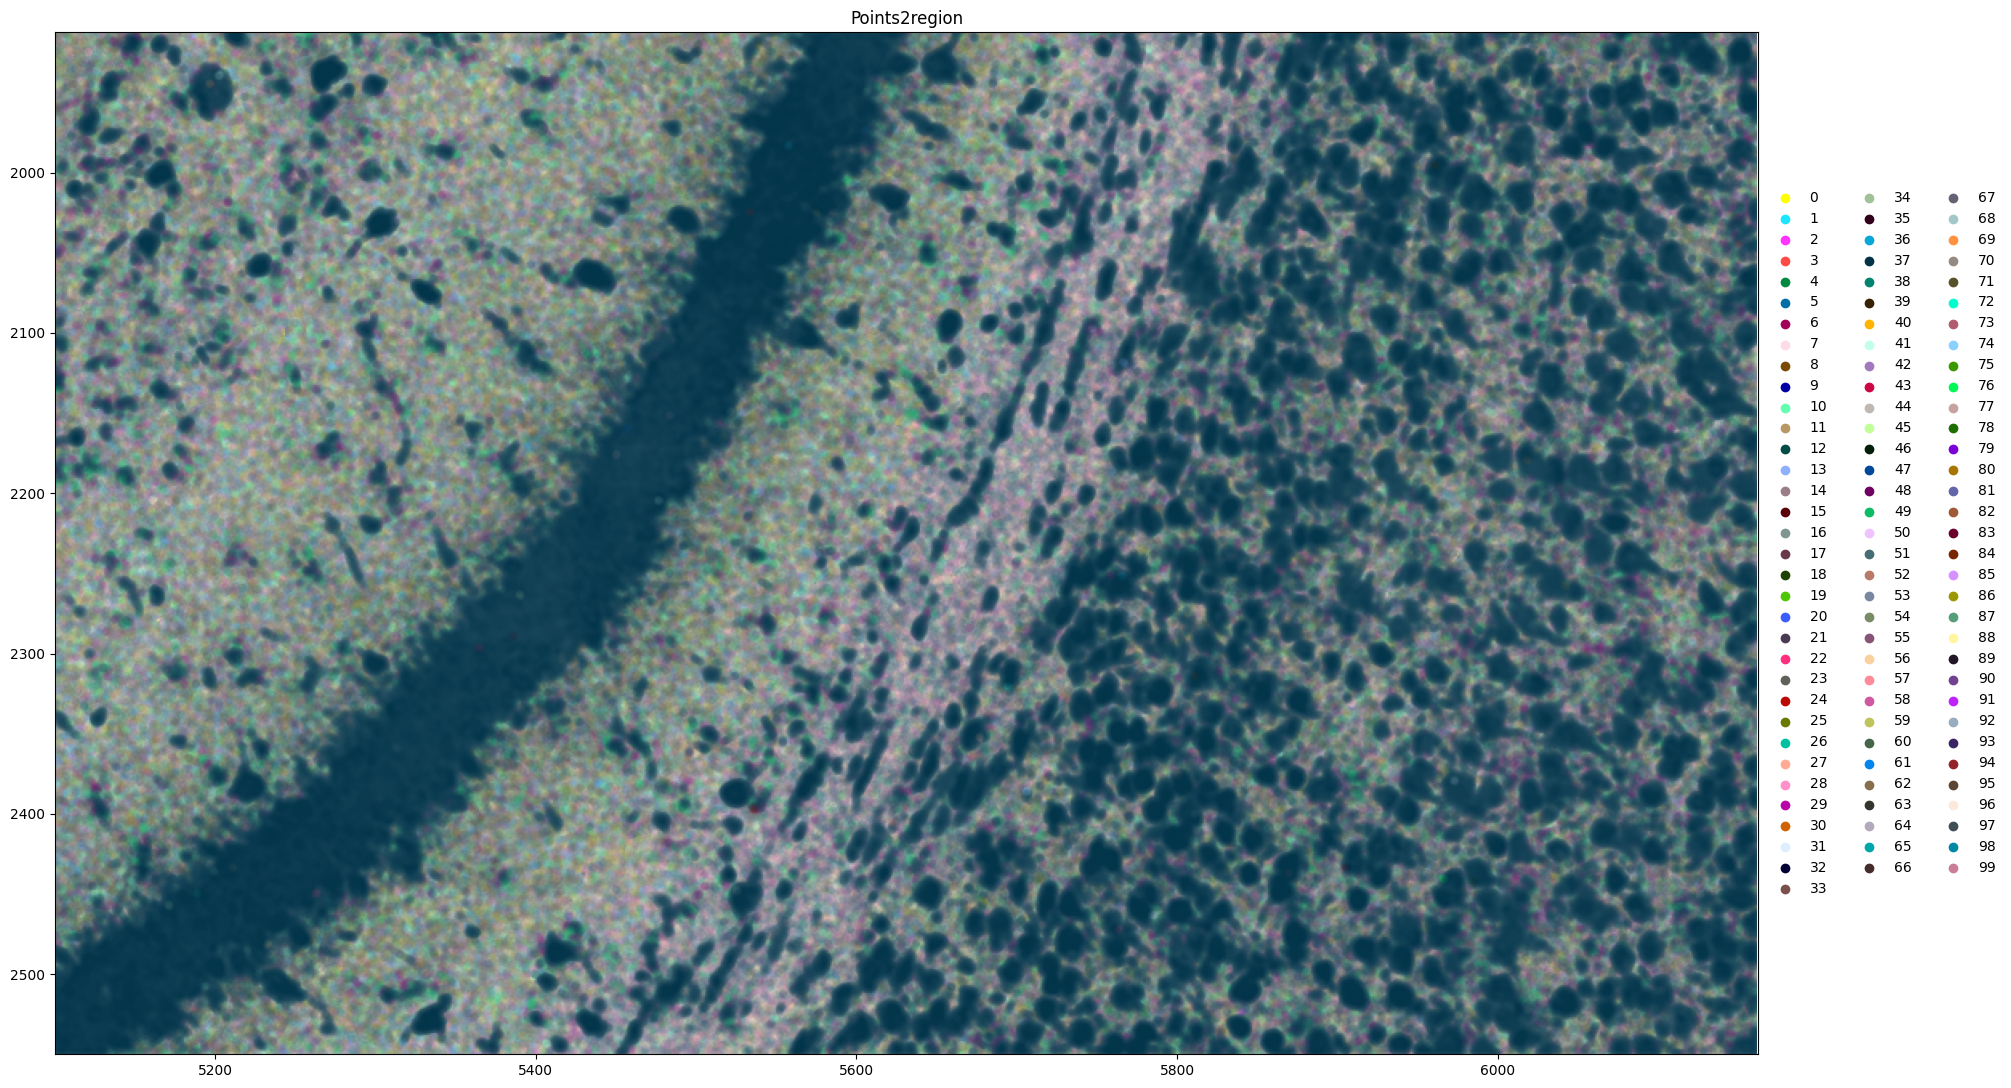

In [5]:
sdata.pl.render_points("transcripts", color="points2region", size=5.0).pl.show(title="Points2region", coordinate_systems="global", figsize=(20, 20))